In [1]:
from game import *

game_settings = BIG_tool_use_advanced_2_5
game_settings.gameSize = 224 # for compatibility with brain's expected size
G = discreteGame(game_settings) # kind of a waste; will only call this object to generate random versions of itself

from RL_helper import *

from visual_transformer import *
device = torch.device('cuda:1') # doing this on the P40

symbol_action_map = {1: 1, 2: 2, 3: 3, 4: 4} # changing this to the 5-output version

# Next, I need to set up the brain itself
old_brain = DefaultAgentBrain()
old_brain.load_state_dict(torch.load('brain_checkpoints/brain_weights_tutorial1_v3_batch95000.pth', weights_only=True, map_location='cpu'))

brain = DefaultAgentBrain(5)
brain.img_enc = old_brain.img_enc
brain.img_dec = old_brain.img_dec
brain = brain.to(device)

from RL_logic_solver import * # convenient way to get fake, logical traces

def average_return(bb):
    """The average return (at the end of the seeds alone) from a buffer-buffer"""
    s = torch.zeros(bb[0].returns[:, 0].size(), device = bb[0].returns[:, 0].device)
    for b in bb: 
        #s += bb[0].returns[:, 0]
        s += b.returns[:, 0]
    return torch.sum(s).item()/(len(bb) * bb[0].returns.size()[0])


pygame 2.6.1 (SDL 2.28.4, Python 3.12.8)
Hello from the pygame community. https://www.pygame.org/contribute.html


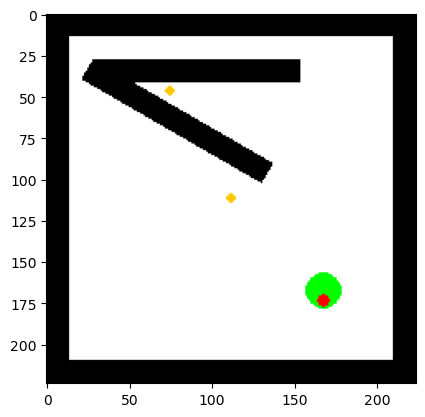

In [2]:
import matplotlib.pyplot as plt
plt.imshow(G.getData())

In [3]:
def quick_display(torch_img):
    clean = torch_img.detach().cpu()
    right_order = torch.permute(clean, (1, 2, 0))
    array = right_order.numpy()
    plt.imshow(array)

In [36]:
def get_settings_batch(batch_size):
    return [G.random_bare_settings(gameSize=224, max_agent_offset=(0.15 + 0.4*i/batch_size)) for i in range(1, batch_size + 1)]

In [37]:
def get_images(settings_batch, device=device):
    batch_size = len(settings_batch)
    img = torch.zeros(batch_size, 224, 224, 3)
    for i in range(batch_size):
        G2 = discreteGame(settings_batch[i])
        img[i] = torch.tensor(G2.getData())
    img = torch.permute(img, (0, 3, 1, 2)).contiguous().to(device)
    return img

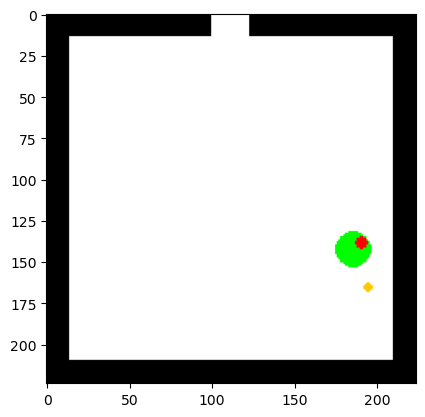

In [39]:
S = get_settings_batch(16)
img = get_images(S)
quick_display(img[0])

In [40]:
img.device

device(type='cuda', index=1)

In [41]:
def get_best_moves(settings_batch, device=device):
    moves = []
    for settings in settings_batch:
        G = discreteGame(deepcopy(settings))
        moves.append(best_move_forward(G))
    return torch.tensor(moves, device=device).unsqueeze(1)

In [46]:
S = get_settings_batch(16)

moves = get_best_moves(S)
moves

tensor([[1],
        [3],
        [1],
        [3],
        [4],
        [4],
        [1],
        [3],
        [4],
        [4],
        [3],
        [4],
        [3],
        [3],
        [3],
        [4]], device='cuda:1')

In [47]:
# tolerable. Fails to learn again, I'll get more traces

In [50]:
S = get_settings_batch(16)
moves = get_best_moves(S)
imgs = get_images(S)

inp = torch.zeros((16, 1), device=device, dtype=torch.long)
probs = brain(inp, imgs, ret_imgs=False)
print(probs.size())
probs

torch.Size([16, 5, 1])


tensor([[[ 0.1748],
         [-0.6620],
         [-0.0864],
         [ 0.7505],
         [-0.1153]],

        [[ 0.8133],
         [-0.5782],
         [-0.4227],
         [ 0.7439],
         [-0.0914]],

        [[ 0.5690],
         [-0.8395],
         [-0.3650],
         [ 0.7850],
         [-0.0603]],

        [[ 0.3324],
         [-0.4690],
         [-0.3286],
         [ 0.3994],
         [-0.5621]],

        [[ 0.4631],
         [-0.9906],
         [-0.1675],
         [ 0.5489],
         [-0.6472]],

        [[ 0.5338],
         [-0.6561],
         [ 0.0137],
         [ 0.5106],
         [-0.4100]],

        [[ 0.5198],
         [-0.6906],
         [-0.3324],
         [ 0.6408],
         [-0.0540]],

        [[ 0.3146],
         [-0.4514],
         [-0.0894],
         [ 0.7099],
         [-0.2193]],

        [[ 0.0925],
         [-0.8788],
         [-0.0780],
         [ 1.1643],
         [-0.5377]],

        [[ 0.6785],
         [-0.5238],
         [-0.4219],
         [ 0.2503],
  

In [52]:
ent_criterion = nn.CrossEntropyLoss()

L = torch.sum(ent_criterion(probs, moves))
L

tensor(1.4170, device='cuda:1', grad_fn=<SumBackward0>)

In [53]:
# ok, we have a plan